<a href="https://colab.research.google.com/github/akibkhan1/skin-lesion-classification/blob/main/Skin_Lesion_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Lesion Classification using transfer learning on various pretrained models

**Authors:**
<br>
Akib Mohammed Khan, Alif Asharafee, Fahim Shahriar Khan,
<br>
Islamic University of Techonology.

## Import models

In [ ]:
import os
import zipfile
import random
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from shutil import copyfile, move

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3383206838369660686, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12139748307142693936
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Download training data

In [ ]:
!gdown --id 15w8elcm9BwfG2-bU-UOLtRBiiaGdpjr0

Downloading...
From: https://drive.google.com/uc?id=15w8elcm9BwfG2-bU-UOLtRBiiaGdpjr0
To: /content/skin-lesion-split.zip
3.60GB [00:59, 60.1MB/s]


In [ ]:
!unzip skin-lesion-split.zip

## Choose model to train

In [ ]:
BASE_MODEL='DenseNet121'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL == 'MobileNet':
    from keras.applications.mobilenet_v2 import MobileNetV2 as PTModel, preprocess_input
elif BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET50':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [ ]:
base_pretrained_model = PTModel(input_shape =  (400,400,3), 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = True

29089792/29084464 [==============================] - 0s 0us/step


## Freeze initial layers

In [ ]:
count=0
for layer in model.layers[:]:
  layer.trainable = False
  count+=1
  if count == 26:
    break

In [ ]:
base_pretrained_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 406, 406, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 200, 200, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 200, 200, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

## Apply Transfer Learning

In [ ]:
last_layer = base_pretrained_model.get_layer('conv5_block16_concat')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 1024)


In [ ]:
from tensorflow.keras.optimizers import Adam

x = layers.BatchNormalization()(last_output)
x = layers.SpatialDropout2D(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)           

model = Model(base_pretrained_model.input, x)

model.compile(optimizer = Adam(lr=0.0001), 
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 406, 406, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 200, 200, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 200, 200, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

##Create Data Generators for Training, Validation and Test dataset

In [ ]:
TRAINING_DIR = "/content/skin-lesion-split/training/"

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (400, 400),
    batch_size = 24,
    class_mode = 'categorical'
)

VALIDATION_DIR = "/content/skin-lesion-split/validation/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (400, 400),
    batch_size = 24,
    class_mode = 'categorical'
)

Found 1958 images belonging to 6 classes.
Found 222 images belonging to 6 classes.


In [ ]:
TEST_DIR = "/content/skin-lesion-split/testing/"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (400, 400),
    batch_size = 118,
    class_mode = 'categorical'
)

test_x , test_y = next(test_generator)

Found 118 images belonging to 6 classes.


##Specify Callbacks


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('skin-lesion-classification')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

##Training the model

In [ ]:
history = model.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              callbacks = callbacks_list,
                              validation_data=validation_generator)

Epoch 1/20
82/82 [==============================] - 220s 2s/step - loss: 2.1304 - accuracy: 0.4157 - val_loss: 1.6056 - val_accuracy: 0.5721

Epoch 00001: val_loss improved from inf to 1.60556, saving model to skin-lesion-classification_weights.best.hdf5
Epoch 2/20
82/82 [==============================] - 160s 2s/step - loss: 1.0822 - accuracy: 0.6014 - val_loss: 1.4825 - val_accuracy: 0.5270

Epoch 00002: val_loss improved from 1.60556 to 1.48247, saving model to skin-lesion-classification_weights.best.hdf5
Epoch 3/20
82/82 [==============================] - 151s 2s/step - loss: 0.9911 - accuracy: 0.6245 - val_loss: 1.2235 - val_accuracy: 0.5946

Epoch 00003: val_loss improved from 1.48247 to 1.22349, saving model to skin-lesion-classification_weights.best.hdf5
Epoch 4/20
82/82 [==============================] - 151s 2s/step - loss: 0.8767 - accuracy: 0.6845 - val_loss: 1.1042 - val_accuracy: 0.6036

Epoch 00004: val_loss improved from 1.22349 to 1.10422, saving model to skin-lesion-c

##Visualize the results

Text(0.5, 1.0, 'Training and validation loss')

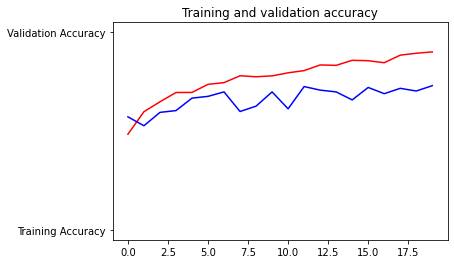

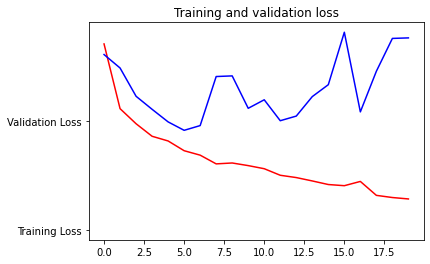

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

## Predict result on unseen data

In [ ]:
t_x, t_y = test_x, test_y
t_yp = model.predict(t_x, verbose=True)

4/4 [==============================] - 10s 1s/step


In [ ]:
count=0
label=[]
pred = []
for i in range(len(t_y)):
  label.append(np.argmax(t_y[i], axis = 0))
  pred.append(np.argmax(t_yp[i], axis = 0))
  #if label == pred:
    #count +=1

#accuracy = (count * 100)/ len(t_y)
#print(accuracy) 
print(label)
print(pred)

In [ ]:
def metrics(ground_truth,pred, cls):
  tp=0
  tn=0
  fp=0
  fn=0
  for i in range(len(ground_truth)):
    if ground_truth[i] == cls and pred[i] == cls:
      tp+=1
    elif ground_truth[i] != cls and pred[i] != cls:
      tn+=1
    elif ground_truth[i] == cls and pred[i] != cls:
      fn+=1
    elif ground_truth[i] != cls and pred[i] == cls:
      fp+=1

  sens = tp / (tp + fn)
  spec = tn / (tn+fp)

  return sens, spec 

In [ ]:
cls_name = {0: "ACK",
            1: "BCC",
            2: "MEL",
            3: "NEV",
            4: "SCC",
            5: "SEK"}
      
for cls in range(6):
  sens,spec = metrics(label,pred,cls)
  print("For %s : Sensitiivity = %.2f , Specificity = %.2f" % (cls_name[cls],sens*100,spec*100) )
  

For ACK : Sensitiivity = 78.38 , Specificity = 90.12
For BCC : Sensitiivity = 67.44 , Specificity = 89.33
For MEL : Sensitiivity = 66.67 , Specificity = 100.00
For NEV : Sensitiivity = 92.31 , Specificity = 98.10
For SCC : Sensitiivity = 30.00 , Specificity = 88.89
For SEK : Sensitiivity = 75.00 , Specificity = 96.23


In [ ]:
!gdown --id '1XrieFe-vJFfcg1-NGUrtvz63QTiukiTi'

Downloading...
From: https://drive.google.com/uc?id=1XrieFe-vJFfcg1-NGUrtvz63QTiukiTi
To: /content/path_label.csv
100% 56.9k/56.9k [00:00<00:00, 26.7MB/s]


In [ ]:
files = pd.read_csv('path_label.csv')
files.head(5)

,img_id,diagnostic
0,PAT_1516_1765_530.png,NEV
1,PAT_46_881_939.png,BCC
2,PAT_1545_1867_547.png,ACK
3,PAT_1989_4061_934.png,ACK
4,PAT_684_1302_588.png,BCC


In [ ]:
files[files['diagnostic'] == 'NEV'].iloc

img_id        PAT_1516_1765_530.png
diagnostic                      NEV
Name: 0, dtype: object